# Evolving Functions with `pg.ext.matfun`

PyGlove provides an extension library `pg.ext.matfun` for handling low-level mutable functions, which allows searching for an arbitrary function based on predefined instructions. This notebook illustrates how to evolve a function and do symbolic regression based on this extension library.

In [ ]:
!pip install pyglove

import pyglove as pg
from pyglove.ext.mutfun import Instruction, Function, Assign, Var, BinaryOperator, Add, Substract, Multiply, Divide

## Creating a mutable function and call it

In [2]:
f = Function(
    'f',
    [
        Assign('y', 2),
        Var('x') + Var('y')
    ],
    args=['x'])

print(f)
f.compile()
print('f(1) =', f(1))

def f(x):
  y = 2
  return x + y
f(1) = 3


In [3]:
# A bad function can be caught with `Function.compile`.
g = Function(
    'g', 
    [
        Var('x') + Var('y')
    ])
print(g)
try:
  g.compile()
except ValueError as e:
  print('Compilation failed:', e)

def g():
  return x + y
Compilation failed: Undefined variables {'x', 'y'} found at 'body[0]'.


## Evolving a mutable function

In [4]:
seed = Function('seed', [
  Assign('y', Var('x') * 2),
  Assign('z', 3 + Var('x')),
  Var('y') + Var('z'),
], args=['x'])

print(seed)
print('seed(2) =', seed(2))

def seed(x):
  y = x * 2
  z = 3 + x
  return y + z
seed(2) = 9


In [5]:
import random

def evolve_fn(k, v, p):
  if isinstance(v, BinaryOperator):
    other_binary_ops = list(Instruction.select_types(
        lambda cls: (issubclass(cls, BinaryOperator)
                     and cls not in (BinaryOperator, v.__class__))))
    another_op = random.choice(other_binary_ops)
    return another_op(**v.sym_init_args)
  elif isinstance(v, Var):
    vars = v.seen_vars() - set([v.name, v.parent_func().name])
    if vars:
      return Var(random.choice(list(vars)))
  return v
    
def evolve_weights(mt, k, v, p):
  # Evolving only binary op and var.
  if isinstance(v, (BinaryOperator, Var)):
    return 1.0
  return 0.0


def search():
  search_space = pg.evolve(seed, evolve_fn, weights=evolve_weights)
  search_algo = pg.evolution.Evolution(
      (pg.evolution.selectors.Random(10)
      >> pg.evolution.selectors.Top(1)
      >> pg.evolution.mutators.Uniform()),
      population_init=(pg.geno.Random(), 1),
      population_update=pg.evolution.selectors.Last(20))

  for example, feedback in pg.sample(
      search_space, search_algo, num_examples=5):
    print(example)
    reward = example(2)
    feedback(reward)
    print(reward)

search()

def seed(x):
  y = x * 2
  z = 3 + x
  return y + z
9
def seed(x):
  y = x * 2
  z = 3 + y
  return y + z
11
def seed(x):
  y = x * 2
  z = 3 + y
  return x + z
9
def seed(x):
  y = x * 2
  z = 3 / y
  return y + z
4.75
def seed(x):
  y = x * 2
  z = 3 ** y
  return y + z
85


## Symbolic regression

Create a random program with random chosen `BinaryOperator`s.

In [6]:
def random_program(
    max_lines: int = 5, min_lines: int = 1, use_constants=(1, 2)):
  num_lines = random.randint(min_lines, max_lines)
  instructions = []
  binary_ops = list(Instruction.select_types(
      lambda cls: issubclass(cls, BinaryOperator) and cls is not BinaryOperator))
  def random_operand(max_var_index):
    if random.choice([True, False]):
      # Use variable.
      var_index = random.randint(0, max_var_index)
      return Var(f'v{max_var_index}')
    else:
      return random.choice(use_constants)

  def random_op(max_var_index):
    return random.choice(list(binary_ops))(
        random_operand(max_var_index),
        random_operand(max_var_index))

  for i, _ in enumerate(range(num_lines)):
    ins = Assign(f'v{i + 1}', random_op(i))
    instructions.append(ins)
  return Function('h', instructions, args=['v0'])


Coding symbolic regression:

In [11]:
from typing import List, Tuple

def symbolic_regress(seed, 
                     truth_fn, 
                     sample_points: List[Tuple[float]], 
                     num_iterations: int = 500):
  labels = [truth_fn(*sample_point) for sample_point in sample_points]

  search_space = pg.evolve(seed, evolve_fn, weights=evolve_weights)
  search_algo = pg.evolution.Evolution(
      (pg.evolution.selectors.Random(20)
      >> pg.evolution.selectors.Top(1)
      >> pg.evolution.mutators.Uniform()),
      population_init=(pg.geno.Random(), 1),
      population_update=pg.evolution.selectors.Last(100))

  losses = []
  min_loss, best_example = None, None
  for example, feedback in pg.sample(
      search_space, search_algo, num_examples=num_iterations):
    example.prune()
    try:
      prediction = [example(*args) for args in sample_points]
      loss = sum([(l - p) ** 2 for l, p in zip(labels, prediction)]) / len(labels)
    except (ZeroDivisionError, OverflowError):
      loss = 1e10
    feedback(-loss)
    if min_loss is None or min_loss > loss:
      min_loss, best_example = loss, example
    losses.append(loss)
  return (best_example, min_loss, losses)

seed = random_program()
print(seed)
best_example, min_loss, losses = symbolic_regress(
    seed,
    lambda x: x ** 2 + x, 
    [(1,), (2,), (-1,), (3,), (5,), (7,), (-3,), (-5,)])

print(best_example, min_loss)

def h(v0):
  v1 = v0 + 2
  return v2 = 2 // v1
def h(v0):
  v1 = v0 ** 2
  return v2 = 2 + v1 14.875


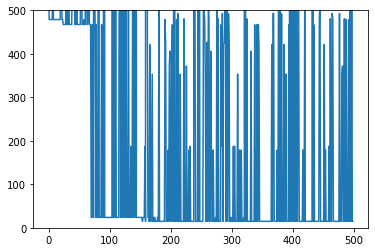

In [ ]:
def plot(losses):
  import matplotlib.pyplot as plt
  plt.ylim(top=500)
  plt.plot(range(len(losses)), losses)
  
plot(losses)